In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

from scipy.sparse import csr_matrix

from src.ItemItemRecommender import ItemItemRecommender
from sklearn.model_selection import train_test_split


from src.item_item_prototype import get_ratings_data, load_movies

import warnings
warnings.filterwarnings('ignore')

In [63]:
ratings_contents, ratings_as_mat = get_ratings_data()

In [64]:
ratings_contents.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [65]:
# So we can get movie titles
movies = load_movies()
movies.set_index('movie_id',inplace=True)

## 2) 

In [66]:
df = ratings_contents.pivot_table(values='rating',index='user',columns='movie')

Min number of ratings: 20


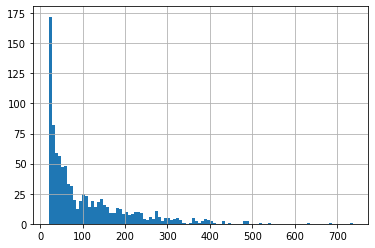

In [67]:
ratings = (df > 0).sum(axis=1)
ratings.hist(bins=100)
print('Min number of ratings: {}'.format(ratings.min()))

Min number of ratings: 1


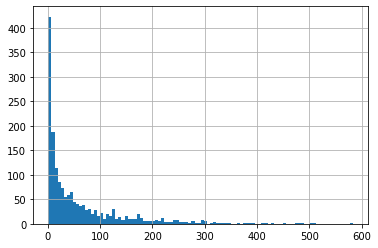

In [68]:
ratings = (df > 0).sum(axis=0)
ratings.hist(bins=100)
print('Min number of ratings: {}'.format(ratings.min()))

## 3)

In [69]:
number_ratings = (ratings_contents['rating'] > 0).sum()
density = number_ratings / (df.shape[0] * df.shape[1])
print('The desnsity is: {} '.format(density))


The desnsity is: 0.06304669364224531 


## 4 / 5)

There is going to be an issue with cold start as there seem to be a lot of movies with only one rating.  So we are going to be lacking enough information for many of the items.  For simplicity we can use a mean value for those items.  A better method might be to use the content data for a content recommendation.   

Because we have the data in the format we currently do we can use the basic cross validation method (we will have to create the utility matrix for both after the split)

In [86]:
train, test = train_test_split(ratings_contents, random_state = 100)

In [87]:
def hist_of_df(df, user_item):
    pivot = df.pivot_table(values='rating',index='user',columns='movie')
    ratings = (pivot > 0).sum(axis=user_item)
    ratings.hist(bins=100)
    print('Min number of ratings: {}'.format(ratings.min()))

Min number of ratings: 11


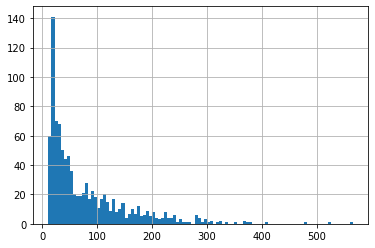

In [88]:
#Hist of users
hist_of_df(train, 1)

Min number of ratings: 1


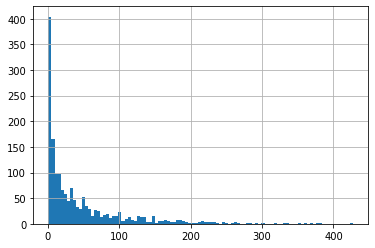

In [89]:
# Hist of Items
hist_of_df(train, 0)

In [90]:
# Number of users that are in train and not test
len( np.setdiff1d(test.user.unique(), train.user.unique()))

0

In [91]:
# Number of movies in train and not test
len( np.setdiff1d(test.movie.unique(), train.movie.unique()))

51

## 6) 

In [92]:
average_rating = ratings_contents.groupby('movie').mean()['rating']

In [93]:
movies.loc[average_rating.idxmax()]

movie_title    Great Day in Harlem, A (1994)
Name: 814, dtype: object

## Part 2)

I am going to go to using a sparse matrix for this as this is the more likely format that we will deal with data in this situation as utility matrix are usually very sparse.

In [94]:
ratings_as_mat = csr_matrix((train.rating, 
        ((train.user), (train.movie))))

In [95]:
rec = ItemItemRecommender(neighborhood_size=75)
rec.fit(ratings_as_mat)

In [96]:
rec.pred_one_user(user_id=1)

array([0.        , 4.12999623, 3.80897556, ..., 2.79925988, 2.79925988,
       3.70441439])

In [97]:
movies.loc[rec.top_n_recs(user_id=1, n=10)]

,movie_title
movie_id,
308,FairyTale: A True Story (1997)
1457,Love Is All There Is (1996)
749,"MatchMaker, The (1997)"
1458,"Damsel in Distress, A (1937)"
1243,Night Flier (1997)
1382,"Bonheur, Le (1965)"
1383,"Second Jungle Book: Mowgli & Baloo, The (1997)"
1464,"Stars Fell on Henrietta, The (1995)"
1369,"Forbidden Christ, The (Cristo proibito, Il) (1..."


## Part 3)

RMSE will penelize a bad prediction on a low rated movie as much as a hight rated movie.  We really dont care if we predicted a movie will get 3 stars when the user rated it 1 star if we got the right response for the high rated movies as the user should never see the bad rating.

We can modify the RMSE to only include the top movies the user liked.  There are also weighted ranking methods that can be used.

In [98]:
# User 9 on this split seems to have a few ratings to look at

test.groupby('user').count().head(15)

,movie,rating,timestamp
user,,,
1,62,62,62
2,15,15,15
3,15,15,15
4,8,8,8
5,40,40,40
6,51,51,51
7,104,104,104
8,13,13,13
9,5,5,5


In [99]:
user_nine = test[test.user == 9]

In [100]:
predictions = rec.pred_one_user(user_id=9)

In [101]:
user_nine['prediction'] = predictions[test[test.user == 9].movie.values]
user_nine

,user,movie,rating,timestamp,prediction
39473,9,402,4,886959343,0.000000
30909,9,483,5,886960056,3.957755
12610,9,507,4,886959343,3.510620
92453,9,385,5,886960055,0.000000
5266,9,521,4,886959343,3.503176
